# Project 4 
## Assessing the 2020 Democratic Presidential Candidates using NLP

In [3]:
import numpy as np
import pandas as pd
import requests
import pickle
import json
import re
import string
import nltk
import csv 
from bs4 import BeautifulSoup
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models, similarities, matutils
import logging
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
file = open('dic_7_t_par.pkl', "rb")
dic =pickle.load(file)

In [5]:
for k,v in dic.items():
    print(k, len(dic[k]), type(v))

WA 344 <class 'list'>
BU 347 <class 'list'>
KL 300 <class 'list'>
BI 304 <class 'list'>
SA 346 <class 'list'>
BL 203 <class 'list'>


In [7]:
dic['BI']

['Joe Biden: (00:32) Oh, they didn’t miss anything. It’s a long race. I took a hit in Iowa and I’ll probably take a hit here. Traditionally Bernie won by 20 points last time. And usually it’s the neighboring senators that do well. But no matter what, I’m still in this for the same reason, we have to restore the soul of this country, bring back the middle class and make sure we bring people together. And so it’s a simple proposition. It doesn’t matter whether it’s this one or the next. I’ve always viewed the first four encounters, two primaries, and two caucuses as the starting point. And so that’s how I view it.',
 'Joe Biden: (01:12) Well, you know that with regard to Senator Sanders, the President wants very much to sic a label on every candidate. We’re going to not only have to win this time, we have to bring along the United States Senate. And Bernie’s labeled himself, not me, a democratic socialist. I think that’s the label that the President’s going to lay on everyone running wit

In [8]:
a=pd.DataFrame.from_dict(dic, orient='index')
deb_df=a.stack().reset_index()
deb_df.columns=['Name', 'Par','db']
deb_df.drop(['Par'],axis=1, inplace=True)
deb_df.set_index('Name', inplace=True)

In [10]:
# Apply a first round of text cleaning techniques

c_ln=['sanders', 'warren', 'bloomberg',  'buttigieg',  'klobuchar', 'biden']

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'\W*\b\w{1,2}\b', '',text)
    reg = re.compile('|'.join(map(re.escape, c_ln)))
    text = reg.sub('', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [12]:
#Let's take a look at the updated text
deb_df.db = pd.DataFrame(deb_df.db.apply(round1))
 
for n, m in {"united states": "united_states", "health care": "healthcare", 'beat donald':'beat_trump',
             'beat trump':'beat_trump', 'defeat trump': 'beat_trump', #'middle class':'middle_class',          
             'new york city':'new_york', 'family':'families','new york city': 'newyork'}.items():
    deb_df.db = deb_df.db.str.replace(n, m)
deb_df.db
deb_df_a=pd.DataFrame()
deb_df_a['db']=deb_df.db.groupby(deb_df.index).sum()
deb_df_a.db[0]  
deb_df_a.index

Index(['BI', 'BL', 'BU', 'KL', 'SA', 'WA'], dtype='object', name='Name')

In [13]:
ind= ['BIDEN', 'BLOOMBERG', 'BUTTIGIEG', 'KLOBUCHAR', 'SANDERS', 'WARREN']

In [14]:
with open('deb_df_a.pkl', 'wb') as picklefile:
    pickle.dump(deb_df_a, picklefile)

In [15]:
# removing additional stop words
add_sw = ['ive', 'youre', 'im', 'got', 'dont', 'say', 'said', 'just', 'let', 'thats', 'year',
          'maybe', 'campaign', 'crosstalk', 'president', 'think','like','pete','utah','heres',
          'weve','senator', 'thing', 'going', 'know', 'mayor', 'make','people','look', 'need',
         'did','actually','come','applause','right', 'the','want','way','country', 'mike', 'does', 'ago',
         'amy', 'joe','pete', 'bernie','time', 'elizabeth','america', 'new', 'hampshire', 'doesn',
         'american', 'donald', 'don', 'tell', 'thank', 'you','yes', 'heres', 'things', 'big',
         'weve', 'mitch','theres','sander','york','city', 'united_states', 'talk','sure','work',
         'state', 'stage','michael', 'steyer', 'tom','amna','nawaz','plan','good','day','when',
         'bring','lot', 'able','comes','helps','different', 'job','million', 'world','tonight','thatamy',
         'democrat','school','years', 'americans']
stop_words = text.ENGLISH_STOP_WORDS.union(add_sw)

# Wordclouds

BI


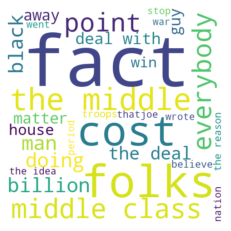

BL


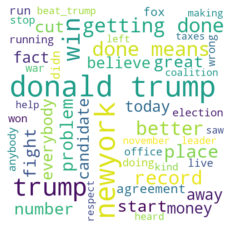

BU


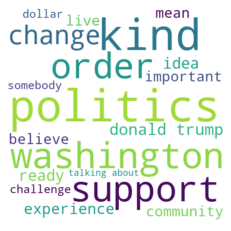

KL


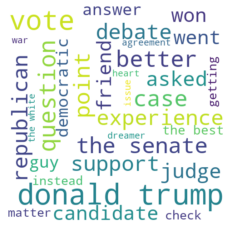

SA


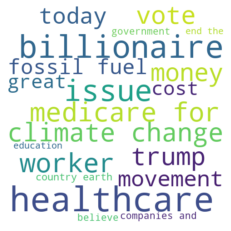

WA


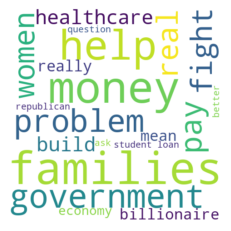

In [16]:
def wcl(lst):
    wordcloud = (WordCloud(width=480, height=480, background_color='white',
                           min_font_size=20,
                           stopwords=stop_words).generate(lst))

    # plot the WordCloud image
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()


for c,i in zip(deb_df_a.index,deb_df_a.db):
    print(c)
    wcl(i)

# Countvectorizer

In [17]:

cv = CountVectorizer(stop_words=stop_words,  max_df=0.90)
deb = cv.fit_transform(deb_df.db)
deb_dtm=pd.DataFrame(deb.toarray(), columns=cv.get_feature_names())
deb_dtm.index=deb_df.index
deb_dtm.index

Index(['WA', 'WA', 'WA', 'WA', 'WA', 'WA', 'WA', 'WA', 'WA', 'WA',
       ...
       'BL', 'BL', 'BL', 'BL', 'BL', 'BL', 'BL', 'BL', 'BL', 'BL'],
      dtype='object', name='Name', length=1844)

In [18]:
stop_words = text.ENGLISH_STOP_WORDS.union(add_sw)
cv1 = CountVectorizer(stop_words=stop_words,  max_df=1.0)
deb_a = cv1.fit_transform(deb_df_a.db)
deb_dtm_a=pd.DataFrame(deb_a.toarray(), columns=cv1.get_feature_names())
deb_dtm_a.index=deb_df_a.index
deb_dtm_a.index


Index(['BI', 'BL', 'BU', 'KL', 'SA', 'WA'], dtype='object', name='Name')

# NMF - Non-negative matrix factorization

In [19]:
nmf_model = NMF(6)
doc_topic = nmf_model.fit_transform(deb_dtm)

In [20]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
            # index = ['c1','c2','c3','c4', 'c5', 'c6'],
             columns = deb_dtm.columns)
topic_word

,abhorrent,abide,ability,abolished,abolitionists,abominable,abortion,abortions,abrams,abroad,...,younger,youngest,youngster,youtube,youve,yup,zero,zinger,zip,zone
0,0.000,0.007,0.018,0.000,0.000,0.000,0.00,0.013,0.000,0.000,...,0.000,0.002,0.000,0.008,0.0,0.000,0.000,0.000,0.011,0.000
1,0.000,0.000,0.000,0.004,0.000,0.000,0.00,0.000,0.000,0.047,...,0.000,0.000,0.000,0.000,0.0,0.000,0.003,0.000,0.000,0.000
2,0.000,0.000,0.022,0.000,0.000,0.000,0.00,0.001,0.000,0.000,...,0.004,0.009,0.000,0.000,0.0,0.000,0.207,0.000,0.031,0.000
3,0.001,0.000,0.016,0.000,0.001,0.000,0.00,0.000,0.000,0.000,...,0.010,0.001,0.006,0.000,0.0,0.000,0.018,0.005,0.011,0.000
4,0.000,0.000,0.005,0.000,0.000,0.003,0.00,0.000,0.000,0.009,...,0.000,0.000,0.000,0.000,0.0,0.007,0.000,0.002,0.000,0.000
5,0.019,0.010,0.083,0.001,0.007,0.001,0.03,0.015,0.014,0.040,...,0.002,0.004,0.007,0.017,0.0,0.002,0.000,0.002,0.015,0.024


In [21]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [22]:
display_topics(nmf_model, deb_dtm.columns, 10)


Topic  0
trump, win, beat_trump, party, democrats, fight, democratic, defeat, candidate, election

Topic  1
healthcare, companies, medicare, drug, insurance, industry, drugs, prescription, pay, cost

Topic  2
tax, money, wealth, education, pay, childcare, public, economy, debt, billion

Topic  3
change, climate, trade, agreement, workers, better, deal, fight, issue, farmers

Topic  4
great, working, families, works, government, class, middle, wage, believe, giant

Topic  5
war, house, fact, troops, vote, senate, iraq, policy, congress, white


In [23]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index = deb_dtm.index,
                             columns = ['Beat Trump','Health Care','Education/Childcare'
                                        ,'Congress/Military', 'Climate/Trade Agr',
                                        'Families']
                            )
doc_topic_nmf=doc_topic_nmf.groupby(doc_topic_nmf.index).sum()

top_m = doc_topic_nmf.div(doc_topic_nmf.sum(axis=1), axis=0).round(2)
top_m.index=ind

Text(0.5, 0, 'Topics')

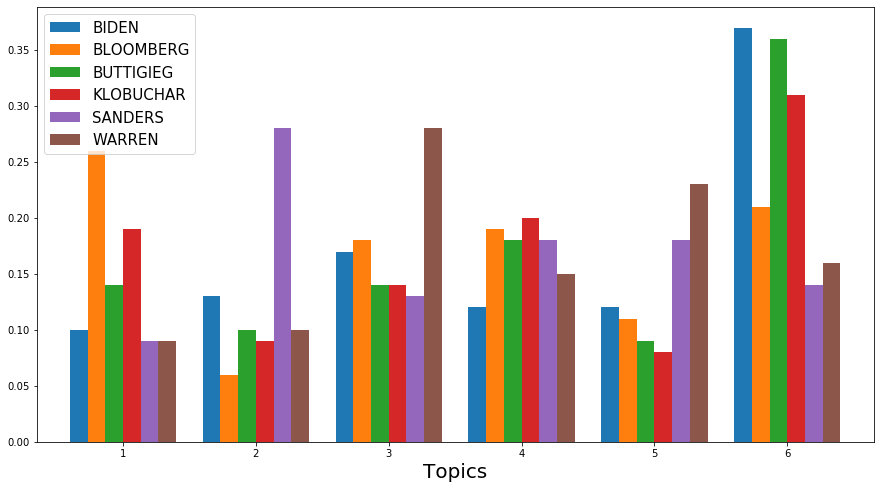

In [24]:

ax = top_m.transpose().plot.bar(figsize=(15,8), width=0.8 )
plt.xticks(np.arange(0,6,1),[1,2,3,4,5,6],  rotation=0)
plt.legend(fontsize=15)
ax.set_xlabel("Topics", fontsize=20)

In [25]:
cosine_similarity_matrix = cosine_similarity(doc_topic_nmf)
print( doc_topic_nmf.index, '\n' ,cosine_similarity_matrix)

Index(['BI', 'BL', 'BU', 'KL', 'SA', 'WA'], dtype='object', name='Name') 
 [[1.         0.85724004 0.98128596 0.95346248 0.79753231 0.82750376]
 [0.85724004 1.         0.90235302 0.95205953 0.76820028 0.84735673]
 [0.98128596 0.90235302 1.         0.98844227 0.77992671 0.79709179]
 [0.95346248 0.95205953 0.98844227 1.         0.79089489 0.80377001]
 [0.79753231 0.76820028 0.77992671 0.79089489 1.         0.84695129]
 [0.82750376 0.84735673 0.79709179 0.80377001 0.84695129 1.        ]]


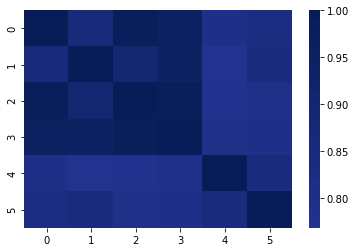

In [26]:
sns.heatmap(cosine_similarity_matrix, center=0, cmap="YlGnBu")

# Gensim

In [30]:
# logging for gensim (set to INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [31]:
deb

<1844x5407 sparse matrix of type '<class 'numpy.int64'>'
	with 26768 stored elements in Compressed Sparse Row format>

In [32]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(deb.transpose())

In [33]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [34]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=6, id2word=id2word, passes=10)

2020-05-21 06:51:12,721 : INFO : using symmetric alpha at 0.16666666666666666
2020-05-21 06:51:12,723 : INFO : using symmetric eta at 0.16666666666666666
2020-05-21 06:51:12,726 : INFO : using serial LDA version on this node
2020-05-21 06:51:12,734 : INFO : running online (multi-pass) LDA training, 6 topics, 10 passes over the supplied corpus of 1844 documents, updating model once every 1844 documents, evaluating perplexity every 1844 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-21 06:51:14,220 : INFO : -10.113 per-word bound, 1107.5 perplexity estimate based on a held-out corpus of 1844 documents with 30583 words
2020-05-21 06:51:14,221 : INFO : PROGRESS: pass 0, at document #1844/1844
2020-05-21 06:51:15,408 : INFO : topic #4 (0.167): 0.005*"healthcare" + 0.005*"trump" + 0.003*"getting" + 0.003*"question" + 0.003*"trade" + 0.003*"war" + 0.003*"agreements" + 0.003*"reason" + 0.003*"support" + 0.003*"clear"
2020-05-21 06:51:15,409 : INFO : topic #5 (0.167):

2020-05-21 06:51:23,113 : INFO : topic #0 (0.167): 0.006*"means" + 0.006*"families" + 0.006*"fact" + 0.005*"money" + 0.005*"matter" + 0.004*"fight" + 0.004*"problem" + 0.004*"washington" + 0.003*"jobs" + 0.003*"community"
2020-05-21 06:51:23,115 : INFO : topic #1 (0.167): 0.014*"trump" + 0.006*"war" + 0.005*"vote" + 0.005*"support" + 0.005*"beat_trump" + 0.005*"change" + 0.005*"deal" + 0.004*"believe" + 0.004*"win" + 0.004*"senate"
2020-05-21 06:51:23,116 : INFO : topic diff=0.075581, rho=0.377964
2020-05-21 06:51:23,994 : INFO : -8.182 per-word bound, 290.4 perplexity estimate based on a held-out corpus of 1844 documents with 30583 words
2020-05-21 06:51:23,995 : INFO : PROGRESS: pass 6, at document #1844/1844
2020-05-21 06:51:24,512 : INFO : topic #0 (0.167): 0.006*"means" + 0.006*"families" + 0.006*"fact" + 0.005*"money" + 0.005*"matter" + 0.004*"fight" + 0.004*"problem" + 0.004*"washington" + 0.003*"jobs" + 0.003*"understand"
2020-05-21 06:51:24,513 : INFO : topic #5 (0.167): 0.010

In [35]:
lda.print_topics(num_words=5)

2020-05-21 06:51:28,697 : INFO : topic #0 (0.167): 0.006*"means" + 0.006*"fact" + 0.006*"families" + 0.005*"matter" + 0.005*"money"
2020-05-21 06:51:28,699 : INFO : topic #1 (0.167): 0.015*"trump" + 0.006*"war" + 0.005*"vote" + 0.005*"support" + 0.005*"beat_trump"
2020-05-21 06:51:28,701 : INFO : topic #2 (0.167): 0.008*"great" + 0.005*"money" + 0.005*"class" + 0.005*"trade" + 0.005*"better"
2020-05-21 06:51:28,703 : INFO : topic #3 (0.167): 0.007*"trump" + 0.006*"win" + 0.005*"fight" + 0.005*"fact" + 0.005*"government"
2020-05-21 06:51:28,705 : INFO : topic #4 (0.167): 0.005*"trade" + 0.005*"agreements" + 0.004*"trump" + 0.004*"war" + 0.004*"workers"
2020-05-21 06:51:28,706 : INFO : topic #5 (0.167): 0.010*"tax" + 0.010*"healthcare" + 0.007*"education" + 0.007*"wealth" + 0.006*"pay"


[(0,
  '0.006*"means" + 0.006*"fact" + 0.006*"families" + 0.005*"matter" + 0.005*"money"'),
 (1,
  '0.015*"trump" + 0.006*"war" + 0.005*"vote" + 0.005*"support" + 0.005*"beat_trump"'),
 (2,
  '0.008*"great" + 0.005*"money" + 0.005*"class" + 0.005*"trade" + 0.005*"better"'),
 (3,
  '0.007*"trump" + 0.006*"win" + 0.005*"fight" + 0.005*"fact" + 0.005*"government"'),
 (4,
  '0.005*"trade" + 0.005*"agreements" + 0.004*"trump" + 0.004*"war" + 0.004*"workers"'),
 (5,
  '0.010*"tax" + 0.010*"healthcare" + 0.007*"education" + 0.007*"wealth" + 0.006*"pay"')]

In [36]:
lda.show_topic(topicid=0)


[('means', 0.006240033),
 ('fact', 0.006036224),
 ('families', 0.0059104413),
 ('matter', 0.0050502326),
 ('money', 0.004821701),
 ('fight', 0.0041154833),
 ('problem', 0.0039501674),
 ('washington', 0.003940679),
 ('jobs', 0.0035268082),
 ('understand', 0.0034972108)]

In [37]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [38]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [39]:
# Check out the document vectors in the topic space for the first 5 documents
lda_docs[0:6]

[[(2, 0.98285806)],
 [(3, 0.95582306)],
 [(1, 0.082462505), (2, 0.50219256), (5, 0.40528637)],
 [(3, 0.14970972), (4, 0.5278572), (5, 0.2957967)],
 [(3, 0.9821299)],
 [(3, 0.3731323), (5, 0.6044902)]]

# VADER

In [42]:
analyser = SentimentIntensityAnalyzer()

In [43]:
vdic=defaultdict(list)
for v,i in zip(deb_df.index,deb_df.db):
    a=analyser.polarity_scores(i)
    vdic[v].append(a['compound'])
a=pd.DataFrame.from_dict(vdic, orient='index')
vad=a.stack().reset_index()
vad.columns=['name','b','compound_sentiment']
vad.drop('b', axis=1, inplace=True)
comp= vad.groupby('name').mean()
comp.index=ind

<BarContainer object of 6 artists>

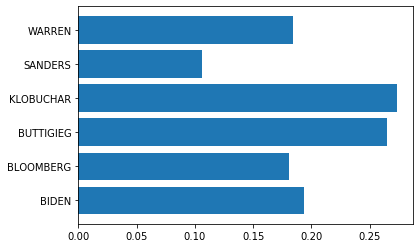

In [44]:
plt.barh(y=comp.index, width='compound_sentiment', data= comp)

# Cosine similarity

In [46]:
stop_words = text.ENGLISH_STOP_WORDS.union(add_sw)
tf=TfidfVectorizer(stop_words=stop_words)

tfidf = tf.fit_transform(deb_df_a.db) 
deb_tf=pd.DataFrame(tfidf.toarray(), columns=tf.get_feature_names())
deb_tf

,abhorrent,abide,ability,abolished,abolitionists,abominable,abortion,abortions,aboutamna,aboutamy,...,youngest,youngster,youpete,youtube,youve,yup,zero,zinger,zip,zone
0,0.009768,0.000000,0.020017,0.000000,0.000000,0.000000,0.008010,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005004,0.000000,0.005795,0.016019
1,0.000000,0.000000,0.018286,0.000000,0.000000,0.017846,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.017846,0.009143,0.000000,0.021174,0.000000
2,0.000000,0.000000,0.021973,0.008578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.008578,0.034311,0.000000,0.008578,0.000000,0.026368,0.008578,0.000000,0.014068
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008824,0.010761,0.021522,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.004044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.015786,0.000000,0.000000,0.008088,0.000000,0.004683,0.000000
5,0.000000,0.007715,0.003953,0.000000,0.007715,0.000000,0.012654,0.006327,0.000000,0.000000,...,0.007715,0.000000,0.000000,0.000000,0.000000,0.000000,0.019764,0.000000,0.004577,0.000000


In [47]:
cosine_similarity_matrix = cosine_similarity(deb_tf)
print( deb_df_a.index, '\n' ,cosine_similarity_matrix)

Index(['BI', 'BL', 'BU', 'KL', 'SA', 'WA'], dtype='object', name='Name') 
 [[1.         0.38104232 0.43135072 0.41274457 0.41694856 0.42331924]
 [0.38104232 1.         0.39653631 0.40318046 0.33568568 0.40145162]
 [0.43135072 0.39653631 1.         0.45124486 0.42246573 0.45130924]
 [0.41274457 0.40318046 0.45124486 1.         0.39557438 0.41781833]
 [0.41694856 0.33568568 0.42246573 0.39557438 1.         0.46530886]
 [0.42331924 0.40145162 0.45130924 0.41781833 0.46530886 1.        ]]


# top 30 words

In [48]:
data_t = deb_dtm_a.transpose()
data_t.head()

Name,BI,BL,BU,KL,SA,WA
abhorrent,1,0,0,0,0,0
abide,0,0,0,0,0,1
ability,4,2,5,0,1,1
abolished,0,0,1,0,0,0
abolitionists,0,0,0,0,0,1


In [49]:
# Find the top  words said by each candidate
top_dict = {}
for c in data_t.columns:
    top = data_t[c].sort_values(ascending=False).head(20)
    top_dict[c]= list(zip(top.index, top.values))
#print(data_t.loc['healthcare'])
top_dict

{'BI': [('fact', 81),
  ('deal', 35),
  ('number', 32),
  ('folks', 27),
  ('trump', 26),
  ('class', 22),
  ('middle', 21),
  ('idea', 21),
  ('making', 20),
  ('money', 19),
  ('guy', 18),
  ('black', 18),
  ('getting', 18),
  ('reason', 18),
  ('single', 17),
  ('billion', 17),
  ('house', 17),
  ('away', 17),
  ('troops', 16),
  ('long', 16)],
 'BL': [('trump', 35),
  ('newyork', 19),
  ('getting', 19),
  ('means', 16),
  ('win', 13),
  ('doing', 13),
  ('better', 13),
  ('record', 12),
  ('states', 11),
  ('democrats', 10),
  ('office', 10),
  ('great', 10),
  ('start', 10),
  ('away', 9),
  ('money', 9),
  ('fight', 9),
  ('today', 9),
  ('cut', 9),
  ('tax', 9),
  ('believe', 9)],
 'BU': [('trump', 34),
  ('ready', 28),
  ('majority', 28),
  ('politics', 28),
  ('order', 26),
  ('future', 26),
  ('change', 26),
  ('somebody', 26),
  ('making', 26),
  ('support', 26),
  ('washington', 26),
  ('war', 25),
  ('win', 24),
  ('party', 24),
  ('talking', 21),
  ('community', 20),
  ('

In [50]:
# Find the number of unique words that each candidate uses
# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for candidate in data_t.columns:
    uniques = data_t[candidate].to_numpy().nonzero()[0].size
    print(candidate, uniques)
    unique_list.append(uniques)

BI 1979
BL 1313
BU 2493
KL 1988
SA 1791
WA 2088
